In [21]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle


from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import load_model

In this part i try to find out if transfer learing will improve the results! I decided to work with VGG16 model.  

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'tomatoe_small',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names = dataset.class_names
n_classes = len(class_names)

Found 4000 files belonging to 10 classes.


In [22]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'TomatoeVillage',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names = dataset.class_names
n_classes = len(class_names)

Found 16011 files belonging to 10 classes.


In [24]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])

rescale = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(-0.2),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomBrightness(0.2)
])


train_ds = train_ds.map(
    lambda x, y: (rescale(x, training=True), y)
)

val_ds = val_ds.map(
    lambda x, y: (rescale(x, training=True), y)
)

test_ds = test_ds.map(
    lambda x, y: (rescale(x, training=True), y)
)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(-0.2),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomBrightness(0.2)
])

more_data = test_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

We are trying the VGG16 model to see if those trained weights can help us with tomatoe leaf decease classification

In [5]:
vgg16_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3)) # resolution of our tomato images

vgg16_base.summary()

This part i a bit hard to understand, but we use the features that the huge VGG16 model has learned and somehow apply them to our training data

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images) # this scales pixel values to an appropriate range.
        features = vgg16_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_ds)
val_features, val_labels =  get_features_and_labels(val_ds)
test_features, test_labels =  get_features_and_labels(test_ds)

#! The test_feature shape is very important! (1632, 8, 8, 512)
test_features.shape
# time = 50m

In [12]:
# We att the feature shape as the input dimensions
# We add a couple of dense layers train on the derived features 
inputs = keras.Input(shape=(8, 8, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(10, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8, 8, 512)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                1290

In [13]:
# this only saves the model weights for the epoch that got the highest val accuracy
modelcheckpoint  = ModelCheckpoint(filepath="feature_extraction_vgg16.tf",save_best_only=True, monitor="val_loss")
callback_list = [modelcheckpoint]

In [15]:
history = model.fit(train_features,train_labels, 
                              epochs=30, validation_data=(val_features, val_labels),
                              callbacks=callback_list)

# val acc 27%

Epoch 1/30
400/400 [==============================] - ETA: 0s - loss: 5.2528 - accuracy: 0.1309INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


400/400 [==============================] - 30s 76ms/step - loss: 5.2528 - accuracy: 0.1309 - val_loss: 3.1313 - val_accuracy: 0.1994
Epoch 2/30
400/400 [==============================] - ETA: 0s - loss: 3.7987 - accuracy: 0.1384INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


400/400 [==============================] - 30s 74ms/step - loss: 3.7987 - accuracy: 0.1384 - val_loss: 2.2283 - val_accuracy: 0.1919
Epoch 3/30
400/400 [==============================] - 28s 71ms/step - loss: 2.8565 - accuracy: 0.1482 - val_loss: 2.5955 - val_accuracy: 0.1544
Epoch 4/30
400/400 [==============================] - 28s 70ms/step - loss: 2.4133 - accuracy: 0.1668 - val_loss: 2.3183 - val_accuracy: 0.2000
Epoch 5/30
400/400 [==============================] - 28s 70ms/step - loss: 2.2640 - accuracy: 0.1784 - val_loss: 2.3178 - val_accuracy: 0.1250
Epoch 6/30
400/400 [==============================] - 28s 70ms/step - loss: 2.2125 - accuracy: 0.1859 - val_loss: 2.2419 - val_accuracy: 0.1581
Epoch 7/30
400/400 [==============================] - ETA: 0s - loss: 2.1804 - accuracy: 0.2009INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


400/400 [==============================] - 28s 71ms/step - loss: 2.1804 - accuracy: 0.2009 - val_loss: 2.1413 - val_accuracy: 0.2313
Epoch 8/30
400/400 [==============================] - ETA: 0s - loss: 2.1625 - accuracy: 0.2114INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


400/400 [==============================] - 30s 74ms/step - loss: 2.1625 - accuracy: 0.2114 - val_loss: 2.0339 - val_accuracy: 0.2706
Epoch 9/30
400/400 [==============================] - 29s 72ms/step - loss: 2.1386 - accuracy: 0.2116 - val_loss: 2.0596 - val_accuracy: 0.2669
Epoch 10/30
400/400 [==============================] - ETA: 0s - loss: 2.1208 - accuracy: 0.2141INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


400/400 [==============================] - 30s 74ms/step - loss: 2.1208 - accuracy: 0.2141 - val_loss: 2.0268 - val_accuracy: 0.2512
Epoch 11/30
400/400 [==============================] - ETA: 0s - loss: 2.1132 - accuracy: 0.2227INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


400/400 [==============================] - 29s 72ms/step - loss: 2.1132 - accuracy: 0.2227 - val_loss: 2.0148 - val_accuracy: 0.2675
Epoch 12/30
400/400 [==============================] - 29s 72ms/step - loss: 2.0995 - accuracy: 0.2250 - val_loss: 2.0219 - val_accuracy: 0.2425
Epoch 13/30
400/400 [==============================] - ETA: 0s - loss: 2.0933 - accuracy: 0.2290INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


400/400 [==============================] - 29s 74ms/step - loss: 2.0933 - accuracy: 0.2290 - val_loss: 2.0100 - val_accuracy: 0.2394
Epoch 14/30
400/400 [==============================] - 30s 75ms/step - loss: 2.0813 - accuracy: 0.2323 - val_loss: 2.0445 - val_accuracy: 0.2837
Epoch 15/30
400/400 [==============================] - ETA: 0s - loss: 2.0821 - accuracy: 0.2338INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


400/400 [==============================] - 30s 74ms/step - loss: 2.0821 - accuracy: 0.2338 - val_loss: 1.9771 - val_accuracy: 0.2387
Epoch 16/30
400/400 [==============================] - 29s 73ms/step - loss: 2.0711 - accuracy: 0.2396 - val_loss: 2.1882 - val_accuracy: 0.1275
Epoch 17/30
400/400 [==============================] - 28s 70ms/step - loss: 2.0649 - accuracy: 0.2474 - val_loss: 2.0252 - val_accuracy: 0.2756
Epoch 18/30
400/400 [==============================] - ETA: 0s - loss: 2.0517 - accuracy: 0.2499INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


400/400 [==============================] - 30s 74ms/step - loss: 2.0517 - accuracy: 0.2499 - val_loss: 1.9718 - val_accuracy: 0.2844
Epoch 19/30
400/400 [==============================] - 29s 71ms/step - loss: 2.0493 - accuracy: 0.2465 - val_loss: 2.0431 - val_accuracy: 0.2862
Epoch 20/30
400/400 [==============================] - ETA: 0s - loss: 2.0340 - accuracy: 0.2574INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


400/400 [==============================] - 31s 76ms/step - loss: 2.0340 - accuracy: 0.2574 - val_loss: 1.9451 - val_accuracy: 0.3462
Epoch 21/30
400/400 [==============================] - 29s 71ms/step - loss: 2.0279 - accuracy: 0.2649 - val_loss: 2.0234 - val_accuracy: 0.2669
Epoch 22/30
400/400 [==============================] - 27s 67ms/step - loss: 2.0263 - accuracy: 0.2592 - val_loss: 1.9457 - val_accuracy: 0.2850
Epoch 23/30
400/400 [==============================] - ETA: 0s - loss: 2.0183 - accuracy: 0.2666INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


400/400 [==============================] - 29s 72ms/step - loss: 2.0183 - accuracy: 0.2666 - val_loss: 1.9357 - val_accuracy: 0.2912
Epoch 24/30
400/400 [==============================] - 30s 74ms/step - loss: 2.0061 - accuracy: 0.2718 - val_loss: 2.1831 - val_accuracy: 0.2537
Epoch 25/30
400/400 [==============================] - ETA: 0s - loss: 2.0056 - accuracy: 0.2759INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


400/400 [==============================] - 30s 74ms/step - loss: 2.0056 - accuracy: 0.2759 - val_loss: 1.9076 - val_accuracy: 0.3044
Epoch 26/30
400/400 [==============================] - 28s 70ms/step - loss: 1.9985 - accuracy: 0.2734 - val_loss: 2.0427 - val_accuracy: 0.1806
Epoch 27/30
400/400 [==============================] - ETA: 0s - loss: 1.9982 - accuracy: 0.2803INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


400/400 [==============================] - 30s 74ms/step - loss: 1.9982 - accuracy: 0.2803 - val_loss: 1.8885 - val_accuracy: 0.3225
Epoch 28/30
400/400 [==============================] - ETA: 0s - loss: 1.9911 - accuracy: 0.2823INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


400/400 [==============================] - 31s 78ms/step - loss: 1.9911 - accuracy: 0.2823 - val_loss: 1.8827 - val_accuracy: 0.3562
Epoch 29/30
400/400 [==============================] - 29s 73ms/step - loss: 1.9795 - accuracy: 0.2862 - val_loss: 1.9113 - val_accuracy: 0.3150
Epoch 30/30
400/400 [==============================] - ETA: 0s - loss: 1.9797 - accuracy: 0.2853INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


INFO:tensorflow:Assets written to: feature_extraction_vgg16.tf\assets


400/400 [==============================] - 30s 75ms/step - loss: 1.9797 - accuracy: 0.2853 - val_loss: 1.8794 - val_accuracy: 0.2781


In [17]:

metrics = pd.DataFrame(history.history)
metrics.tail(10)

,loss,accuracy,val_loss,val_accuracy
20,2.027948,0.264922,2.023430,0.266875
21,2.026286,0.259219,1.945747,0.285000
22,2.018302,0.266641,1.935746,0.291250
23,2.006104,0.271797,2.183107,0.253750
24,2.005594,0.275937,1.907577,0.304375
25,1.998509,0.273359,2.042731,0.180625
26,1.998239,0.280313,1.888527,0.322500
27,1.991105,0.282266,1.882654,0.356250
28,1.979508,0.286172,1.911254,0.315000
29,1.979709,0.285313,1.879412,0.278125


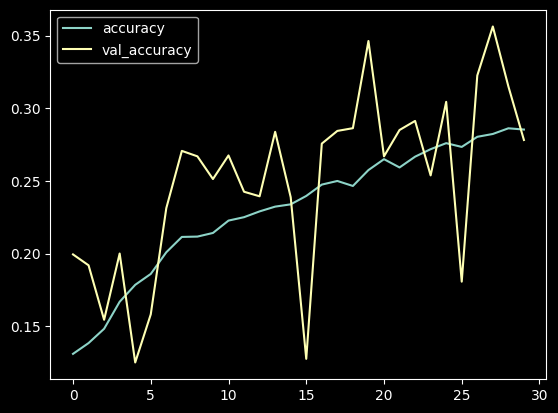

In [18]:
metrics[['accuracy','val_accuracy']].plot()
plt.show()
#* Looks like more epochs could improve the result a bit

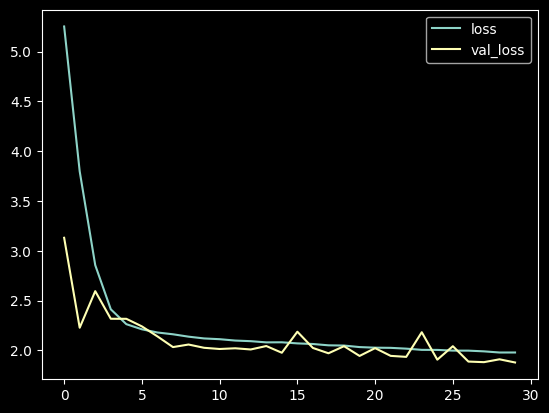

In [19]:
metrics[['loss','val_loss']].plot()
plt.show()

51/51 [==============================] - 0s 9ms/step - loss: 1.8892 - accuracy: 0.2855
Loss = 1.8892364501953125
Accuracy = 0.2855392098426819
Accuracy = 28.6%
        loss  accuracy  val_loss  val_accuracy
25  1.998509  0.273359  2.042731      0.180625
26  1.998239  0.280313  1.888527      0.322500
27  1.991105  0.282266  1.882654      0.356250
28  1.979508  0.286172  1.911254      0.315000
29  1.979709  0.285313  1.879412      0.278125


<Figure size 640x480 with 0 Axes>

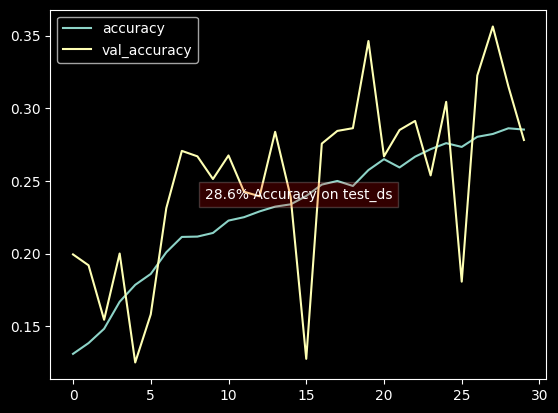

In [23]:
model_scores = model.evaluate(test_features, test_labels)
print(f"Loss = {model_scores[0]}")
print(f"Accuracy = {model_scores[1]}")
acc = model_scores[1]
formatted_acc = "{:.1%}".format(acc)
print(f"Accuracy = {formatted_acc}")

model_metrics = pd.DataFrame(history.history)
print(model_metrics.tail())



plt.clf()
model_metrics[['accuracy','val_accuracy']].plot()

plt.text(0.5, 0.5, f'{formatted_acc} Accuracy on test_ds', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='red', alpha=0.2))
plt.savefig('C:\\Users\\Magnus\\Desktop\\code\\timeSeries\\model_plots\\VGG16_untrained.png')

plt.show()

In [21]:
#
#! you need to save the model and load it. (you did not save it)
#

test_model = keras.models.load_model("CNN_feature_extraction_vgg16.tf")
test_model.evaluate(test_features, test_labels)
# 16% ACC

13/13 [==============================] - 0s 2ms/step - loss: 2.1873 - accuracy: 0.1611


[2.187328577041626, 0.16105769574642181]

Its rather understandable that the model is not doing that well since the tomatoe decease classes are much more narrow than what the model were trained on. Lets see if fine tuning another block of the vgg16 model will improve the results!

In [6]:
# Unfreezeing the last 4 layers
vgg16_base.trainable = True
for layer in vgg16_base.layers[:-4]:
    layer.trainable = False 

In [7]:
# I only add Dense and dropout layers, and of course the preprocess_input()
inputs = keras.Input(shape=(256, 256, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = vgg16_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(10, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), # small learning rate is recommended for transfer learning fine tuning     
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 256, 256, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 256, 256, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               838886

In [8]:
# sometimes i use the checkpoint and sometime not. Have not really figured out how to use them in my workflow. I think they are more useful when you can train for lots of more epochs
modelcheckpoint  = ModelCheckpoint(filepath="C:\\Users\\Magnus\\Desktop\\code\\timeSeries\\my_model\\vgg16_unfreeze_one_block.tf",save_best_only=True, monitor="val_loss")
callback_list    = [modelcheckpoint]

In [9]:
history = model.fit(train_ds, epochs=5, validation_data=val_ds)
# For the big tomato dataset
# time = 280m
# val acc = 43%

Epoch 1/5


100/100 [==============================] - 760s 8s/step - loss: 3.0762 - accuracy: 0.0991 - val_loss: 2.3325 - val_accuracy: 0.1146
Epoch 2/5
100/100 [==============================] - 799s 8s/step - loss: 2.3948 - accuracy: 0.1128 - val_loss: 2.2939 - val_accuracy: 0.1094
Epoch 3/5
100/100 [==============================] - 796s 8s/step - loss: 2.3073 - accuracy: 0.1312 - val_loss: 2.2680 - val_accuracy: 0.1406
Epoch 4/5
100/100 [==============================] - 797s 8s/step - loss: 2.2656 - accuracy: 0.1469 - val_loss: 2.2362 - val_accuracy: 0.2005
Epoch 5/5
100/100 [==============================] - 777s 8s/step - loss: 2.2175 - accuracy: 0.1719 - val_loss: 2.1667 - val_accuracy: 0.1667


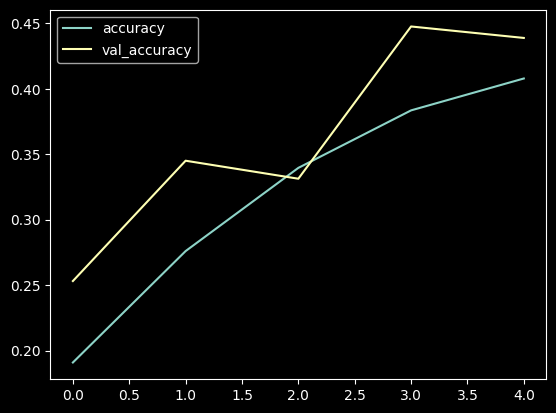

In [16]:
metrics[['accuracy','val_accuracy']].plot()
plt.show()

In [42]:
# I save the model so that i can load it for inference later and also train it more. Since i used a checkpoint callback , i have both the best epoch saved and the final model saved
#! Full tomatoe dataset
model.save('vgg16_unfreeze')

INFO:tensorflow:Assets written to: vgg16_unfreeze\assets


INFO:tensorflow:Assets written to: vgg16_unfreeze\assets


In [11]:
#
#! small tomatoe dataset 
model.save('vgg16_unfreeze_small')

INFO:tensorflow:Assets written to: vgg16_unfreeze_small\assets


INFO:tensorflow:Assets written to: vgg16_unfreeze_small\assets


Lets load the vgg16_unfreeze model and train it some more

In [30]:
model = load_model('vgg16_unfreeze')
epochs = 1
history_222 = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callback_list)
#! del

400/400 [==============================] - ETA: 0s - loss: 1.6027 - accuracy: 0.4388INFO:tensorflow:Assets written to: C:\Users\Magnus\Desktop\code\timeSeries\my_model\vgg16_unfreeze_one_block.tf\assets


INFO:tensorflow:Assets written to: C:\Users\Magnus\Desktop\code\timeSeries\my_model\vgg16_unfreeze_one_block.tf\assets


400/400 [==============================] - 3583s 9s/step - loss: 1.6027 - accuracy: 0.4388 - val_loss: 1.4863 - val_accuracy: 0.4863


Unfreezing the last block and fine tuning the model does improve the results! from around 20% to 40% with it very likely improving further with more epoch training sessions.

I try to save both the model and its metrics. I use pickle for the metrics (saving a dataframe) and a dictionary for the accuracy score. Technically should not test on test set before i am done fine tuning the model, but since the results were so unstable i made that choice. Also its becomin very clear that i should have written functions so that i would not copy paste as much of my code.

In [14]:
history_metrics = pd.DataFrame(history.history)

evaluation_scores = model.evaluate(test_ds)
print(f"Loss = {evaluation_scores[0]}")
acc = evaluation_scores[1]
formatted_acc = "{:.1%}".format(acc)
print(f"Accuracy = {formatted_acc}")

accuracy_dict = {}
epoch = len(history_metrics) + 1

accuracy_dict[f'Epoch {epoch}'] = acc


path = r'C:\Users\Magnus\Desktop\code\timeSeries\history_df_small\\'
with open(path + 'history_metrics', 'wb') as f:
    pickle.dump(history_metrics, f)

with open(path + 'accuracy_dict', 'wb') as f:
    pickle.dump(accuracy_dict, f)

13/13 [==============================] - 68s 5s/step - loss: 2.1769 - accuracy: 0.1851
Loss = 2.1769156455993652
Accuracy = 18.5%


After i have trained the choosen model once and saved the metrics I can just re-run the cell below each time I want to train the model for more epochs. I can change the epoch varible so what number of training iterations i want to run that session.

In [20]:
# folder where we save history / logs
path = r'C:\Users\Magnus\Desktop\code\timeSeries\history_df_small\\'

# Load the pickled DataFrame
with open(path + 'history_metrics', 'rb') as f:
    past_history = pickle.load(f)

# Load the pickled DataFrame
with open(path + 'accuracy_dict', 'rb') as f:
    accuracy_dict = pickle.load(f)

#! In my maybe to simple setup you have to make sure that the model name you load is correct and also the metrics folder. I could probably make this into a function somehow...
model = load_model('vgg16_unfreeze_small')


epochs = 1
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


history_metrics = pd.DataFrame(history.history)

evaluation_scores = model.evaluate(test_ds)
print(f"Loss = {evaluation_scores[0]}")
acc = evaluation_scores[1]
formatted_acc = "{:.1%}".format(acc)
print(f"Accuracy = {formatted_acc}")


#? saving model history metrics and test accuracy
history_concat = pd.concat([past_history, history_metrics], ignore_index=True)
total_epochs = len(history_concat)
accuracy_dict[f'Epoch {total_epochs}'] = acc



with open(path + 'history_metrics', 'wb') as f:
    pickle.dump(history_concat, f)

with open(path + 'accuracy_dict', 'wb') as f:
    pickle.dump(accuracy_dict, f)

model.save('vgg16_unfreeze_small')


13/13 [==============================] - 74s 5s/step - loss: 2.0302 - accuracy: 0.3558
Loss = 2.030210256576538
Accuracy = 35.6%
INFO:tensorflow:Assets written to: vgg16_unfreeze_small\assets


INFO:tensorflow:Assets written to: vgg16_unfreeze_small\assets


In [19]:
history_concat

,loss,accuracy,val_loss,val_accuracy
0,3.076192,0.099063,2.332503,0.114583
1,2.394844,0.112812,2.293883,0.109375
2,2.307272,0.131250,2.268009,0.140625
3,2.265646,0.146875,2.236188,0.200521
4,2.217548,0.171875,2.166676,0.166667
5,2.185566,0.183437,2.142907,0.216146


After 7 epochs on the small tomato dataset i am abandoning the vgg16_unfreeze model.

Trying to unfreeze the last 2 blocks of the vgg16 model and substitute the first one for a conv2d block (similar to have its structured in the original vgg16 model) and the last one with a dense block. This may help the model to extract more features from the tomato pictures. Even though it takes a very long time i will try training on both the small and big dataset to see if there is a difference. There is a risk that the epochs (i am trying 5) is simply to few to determine the dataset is to small.

Another thing that made my code alot more messy than it could have been is that i would overwrite the dataset varible instead of having one dedicated name for the full and small tomato dataset.

In [10]:
epochs = 5
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/5
100/100 [==============================] - 1071s 11s/step - loss: 2.5808 - accuracy: 0.0913 - val_loss: 2.3110 - val_accuracy: 0.1068
Epoch 2/5
100/100 [==============================] - 1127s 11s/step - loss: 2.3168 - accuracy: 0.0956 - val_loss: 2.3083 - val_accuracy: 0.1094
Epoch 3/5
100/100 [==============================] - 1147s 11s/step - loss: 2.3053 - accuracy: 0.1053 - val_loss: 2.3049 - val_accuracy: 0.0964
Epoch 4/5
100/100 [==============================] - 1153s 12s/step - loss: 2.3052 - accuracy: 0.0994 - val_loss: 2.3044 - val_accuracy: 0.0911
Epoch 5/5
100/100 [==============================] - 1120s 11s/step - loss: 2.3048 - accuracy: 0.0928 - val_loss: 2.3016 - val_accuracy: 0.1458


let us also try with the big tomato dataset to see how pronounced the difference will be

In [ ]:
vgg16_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3))


vgg16_base.trainable = True
for layer in vgg16_base.layers[:-8]:
    layer.trainable = False


inputs = keras.Input(shape=(256, 256, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = vgg16_base(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(10, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)
model.summary()

In [20]:
epochs = 5
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

history_metrics = pd.DataFrame(history.history)

evaluation_scores = model.evaluate(test_ds)
print(f"Loss = {evaluation_scores[0]}")
acc = evaluation_scores[1]
formatted_acc = "{:.1%}".format(acc)
print(f"Accuracy = {formatted_acc}")

accuracy_dict = {}
epoch = len(history_metrics) + 1

accuracy_dict[f'Epoch {epoch}'] = acc



#! very important to create new folder for the new model
# this could have been done more elegantly using os or pathlib
path = r'C:\Users\Magnus\Desktop\code\timeSeries\\'

# Create the directory if it doesn't exist
directory = os.path.join(path, 'history_big_freeze_small_ds')
if not os.path.exists(directory):
    os.makedirs(directory)

with open(directory + 'history_metrics', 'wb') as f:
    pickle.dump(history_metrics, f)

with open(directory + 'accuracy_dict', 'wb') as f:
    pickle.dump(accuracy_dict, f)
    
model.save('vgg16_big_unfreeze_small_ds')

13/13 [==============================] - 74s 6s/step - loss: 2.3021 - accuracy: 0.1202
Loss = 2.3020524978637695
Accuracy = 12.0%
INFO:tensorflow:Assets written to: vgg16_big_unfreeze_small_ds\assets


INFO:tensorflow:Assets written to: vgg16_big_unfreeze_small_ds\assets


In [ ]:
# folder where we save history / logs
path = r'C:\Users\Magnus\Desktop\code\timeSeries\history_big_freeze_small_ds\\'
#! obs obs obs obs obs obs


# Load the pickled DataFrame
with open(path + 'history_metrics', 'rb') as f:
    past_history = pickle.load(f)

# Load the pickled DataFrame
with open(path + 'accuracy_dict', 'rb') as f:
    accuracy_dict = pickle.load(f)

#! In my maybe to simple setup you have to make sure that the model name you load is correct and also the metrics folder. I could probably make this into a function somehow...
model = load_model('vgg16_unfreeze_small')


epochs = 1
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


history_metrics = pd.DataFrame(history.history)

evaluation_scores = model.evaluate(test_ds)
print(f"Loss = {evaluation_scores[0]}")
acc = evaluation_scores[1]
formatted_acc = "{:.1%}".format(acc)
print(f"Accuracy = {formatted_acc}")




#? saving model history metrics and test accuracy
history_concat = pd.concat([past_history, history_metrics], ignore_index=True)
total_epochs = len(history_concat)
accuracy_dict[f'Epoch {total_epochs}'] = acc



with open(path + 'history_metrics', 'wb') as f:
    pickle.dump(history_concat, f)

with open(path + 'accuracy_dict', 'wb') as f:
    pickle.dump(accuracy_dict, f)

model.save('vgg16_big_unfreeze_small_ds')

And i will do the same for unfreezing 2 blocks and training on the whole dataset. I should have written a nice function so that i did not need to copy as much code

In [25]:
vgg16_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3))


vgg16_base.trainable = True
for layer in vgg16_base.layers[:-8]:
    layer.trainable = False


inputs = keras.Input(shape=(256, 256, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = vgg16_base(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(10, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem_2  (None, 256, 256, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 256, 256, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          294976    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0   

In [34]:
epochs =1
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

history_metrics = pd.DataFrame(history.history)

evaluation_scores = model.evaluate(test_ds)
print(f"Loss = {evaluation_scores[0]}")
acc = evaluation_scores[1]
formatted_acc = "{:.1%}".format(acc)
print(f"Accuracy = {formatted_acc}")

accuracy_dict = {}
epoch = len(history_metrics) + 1

accuracy_dict[f'Epoch {epoch}'] = acc



#! very important to create new folder for the new model
# this could have been done more elegantly using os or pathlib
path = r'C:\Users\Magnus\Desktop\code\timeSeries\\'

# Create the directory if it doesn't exist
directory = os.path.join(path, 'history_big_freeze_big_ds')
if not os.path.exists(directory):
    os.makedirs(directory)

with open(directory + '/history_metrics', 'wb') as f:
    pickle.dump(history_metrics, f)

with open(directory + '/accuracy_dict', 'wb') as f:
    pickle.dump(accuracy_dict, f)
    
model.save('vgg16_big_unfreeze_big_ds')

51/51 [==============================] - 282s 5s/step - loss: 2.1727 - accuracy: 0.1501
Loss = 2.1727285385131836
Accuracy = 15.0%


In [39]:
path = r'C:\Users\Magnus\Desktop\code\timeSeries\history_big_freeze_big_ds\\'

# Load the pickled DataFrame
with open(path + 'history_metrics', 'rb') as f:
    past_history = pickle.load(f)

# Load the pickled DataFrame
with open(path + 'accuracy_dict', 'rb') as f:
    accuracy_dict = pickle.load(f)

#! In my maybe to simple setup you have to make sure that the model name you load is correct and also the metrics folder. I could probably make this into a function somehow...
model = load_model('vgg16_big_unfreeze_big_ds')


epochs = 1
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


history_metrics = pd.DataFrame(history.history)

evaluation_scores = model.evaluate(test_ds)
print(f"Loss = {evaluation_scores[0]}")
acc = evaluation_scores[1]
formatted_acc = "{:.1%}".format(acc)
print(f"Accuracy = {formatted_acc}")




#? saving model history metrics and test accuracy
history_concat = pd.concat([past_history, history_metrics], ignore_index=True)
total_epochs = len(history_concat)
accuracy_dict[f'Epoch {total_epochs}'] = acc



with open(path + '/history_metrics', 'wb') as f:
    pickle.dump(history_concat, f)

with open(path + '/accuracy_dict', 'wb') as f:
    pickle.dump(accuracy_dict, f)

model.save('vgg16_big_unfreeze_big_ds')

51/51 [==============================] - 315s 6s/step - loss: 2.0209 - accuracy: 0.2727
Loss = 2.020918369293213
Accuracy = 27.3%
INFO:tensorflow:Assets written to: vgg16_big_unfreeze_big_ds\assets


INFO:tensorflow:Assets written to: vgg16_big_unfreeze_big_ds\assets


Pretty good results for only 2 epochs! Seems very likely that the results would be pretty good if we could get the usual 30+ epochs!

Overall fine tuning seems to be very effective. Maybe there are more suitble models out there for my choosen dataset?